# Homework 2: Deep Learning Diagnostics

**Overview**: HW2 will give you a chance to learn how to diagnose problems with neural networks. This skill will prove to be extremely useful when you need to identify a neural network with undesired accuracy or add improvements to an existing model.

**Background**: You will be given 10 different neural networks, along with other necessities for training, in a pickled format. All networks will be trained on the Fashion-MNIST dataset, and your job is to identify what exactly is wrong with each training experiment.

# Q0. Setting up (0 pts)

## Installing dependencies

Run the code snippet below to import any required dependencies and set up the GPU.

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import random
import numpy as np
import matplotlib
import pandas as pd
import dill
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Tensorboard Setup

Run the following code snippets to set up tensorboard. Note that this will save the tensorboard logs in a "logs" folder in the ```/content/drive/My Drive/logs``` folder (the root folder of your Drive). If you would like to change where the tensorboard logs are saved, change the ```ROOT_LOG_DIR``` path. Whenever training a different model, we recommend changing the sub-directory in which it's stored -- you can change this by changing the ```TENSORBOARD_DIR``` variable.

In [0]:
%load_ext tensorboard

In [0]:
import torch
ROOT_LOG_DIR = "/content/drive/My Drive/logs"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
import os
import dill

repo_path = "/content/Homework2_Resources/"

if not os.path.isdir(repo_path):
  !git clone https://github.com/CIS522/Homework2_Resources.git

fashion_mnist_test_set_path = "/content/Homework2_Resources/fashion_test_inputs.dill"
fashion_mnist_data = None
with open(fashion_mnist_test_set_path, 'rb') as mnist_f:
  fashion_mnist_data = dill.load(mnist_f)

CIFAR_test_set_path = "/content/Homework2_Resources/cifar_10_test_inputs.dill"
CIFAR_data = None
with open(CIFAR_test_set_path, 'rb') as cifar_f:
  CIFAR_data = dill.load(cifar_f)

# If you perform any pre-processing to test_df, please include that pre-processing in this function!
def generate_fashion_mnist_output(generate_predictions_func):
  return generate_predictions_func(fashion_mnist_data)

# If you perform any pre-processing to test_df, please include that pre-processing in this function!
def generate_cifar_output(generate_predictions_func):
  return generate_predictions_func(CIFAR_data)

In [0]:
test_case_1e = None
test_case_3b = None

# Q1. Introduction to Neural Network Diagnoses, Part 1 (10 pts)

**Understanding the Dataset**

The first step to machine learning is to understand the dataset that you're given. Therefore, familiarize yourself with the Fashion-MNIST dataset. We recommend reading the paper published about the dataset, which is detailed [here](https://arxiv.org/pdf/1708.07747.pdf).

**Q1.a (1 pt):** In the writeup, explain at a high level what the dataset is (i.e. what are the specifications of the input data and associated labels).

##Creating a Benchmark (10 pts)##

Below, we will setup a working model for the Fashion-MNIST dataset. This will serve as a benchmark for your analysis in Q2.

**PyTorch Dataloaders**

The first is to create a dataloader:

**Q1.b (1 pt):** Create a training, testing, and validation dataloader for the Fashion-MNIST dataset using the data that we provide you. The split should be 70/10/20 respectively. Using any of the three dataloaders, visualize an image from the dataloader and put that image in your writeup.

**Note:** Fashion-MNIST is a highly used dataset, but we **do not** want you to use the built in PyTorch Dataset / Dataloader for Fashion-MNIST or any form of this dataset that you find online. We've provided the data for you to use, and so you should be making a custom Dataset / Dataloader, **only** using the data we've given you.

**Data:** We've given you the data in the form of two pickled files:
*   fashion_input_data.dill
*   fashion_labels.dill

The first pickled file contains the input data that you should be training with as a pickled 3-dimensional numpy array. The images are 28x28, so each individual image is stored along the first axis (i.e. if you index into [7, 3, 5] you're indexing into the pixel at row 3, column 5 of image).

The second pickled file is a numpy array that contains the labels for the input data stored as numbers from 0-9.



In [0]:
with open("/content/drive/My Drive/Colab Notebooks/Release/data/fashion_mnist_data/fashion_input_data.dill",'rb') as fid:
  fashion_data  = dill.load(fid)
with open("/content/drive/My Drive/Colab Notebooks/Release/data/fashion_mnist_data/fashion_labels.dill",'rb') as fl:
  fashion_label = dill.load(fl)



In [0]:
class FashionDataset(Dataset):
    def __init__(self,X,y):
      self.X=fashion_data
      self.y=fashion_label
      

    def __len__(self):
     return len(self.X)

    def __getitem__(self, idx):
      image=self.X[idx]
      label=self.y[idx]
     
      return image,label
       

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(fashion_data,fashion_label, test_size=0.1, random_state=1)  # splitting total as test-10 and train-90
X_train,X_val,Y_train, Y_val = train_test_split(X_train,Y_train,test_size=0.2222, random_state=1) # splitting train-90 as train-70 and val-20 (0.222*90/100 =20)

train=FashionDataset(X_train,Y_train)
test=FashionDataset(X_test,Y_test)
val=FashionDataset(X_val,Y_val)


train_dl=DataLoader(train,batch_size = 50, shuffle="True")
test_dl=DataLoader(test,batch_size = 50, shuffle="True")
val_dl=DataLoader(val,batch_size = 50, shuffle="True")



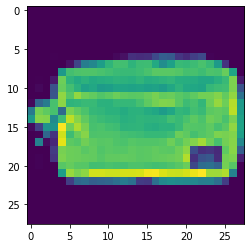

In [0]:
for idx, data in enumerate(train_dl):
  image,label=data
  plt.imshow(image[0].cpu().data)
  if(idx==5):
    break


**Q1.c (2 pts):** Create a neural network model to classify the Fashion-MNIST dataset. Describe your model architecture in your writeup as well as explain your rationale in your writeup.

**Note:** You may not use convolutional layers, **only** linear  layers.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

class MLP(nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    self.fc1 = nn.Linear(784,950)
    self.fc2 = nn.Linear(950,350)
    self.fc3  = nn.Linear(350,10)


  def forward(self, x):
    x = F.leaky_relu(self.fc1(x))
    x = F.leaky_relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [0]:
net=MLP()
net.cuda()
optim = optim.Adam(net.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

In [70]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

MLP(
  (fc1): Linear(in_features=784, out_features=950, bias=True)
  (fc2): Linear(in_features=950, out_features=350, bias=True)
  (fc3): Linear(in_features=350, out_features=10, bias=True)
)

In [0]:
import os
from torch.utils.tensorboard import SummaryWriter
ACCURACY_DIR = "Q8 Final A" # Sub-Directory for storing this specific experiment's logs
LOSS_DIR = "Q8 Final L"
q2_acc_after = SummaryWriter(os.path.join(ROOT_LOG_DIR, ACCURACY_DIR))
q2_loss_after = SummaryWriter(os.path.join(ROOT_LOG_DIR, LOSS_DIR))

In [0]:
%tensorboard --logdir {ROOT_LOG_DIR.replace(" ", "\\ ")}


In [0]:
%tensorboard --logdir {ROOT_LOG_DIR.replace("", "/content/drive/My Drive/logs/Q8 Final L ")

In [0]:
%tensorboard --logdir /content/drive/MyDrive/logs/Q8FinalA

**Q1.d:** Create a training loop that takes in a dataloader of the training set, an optimizer, a loss function, and a model and trains that model. Your training loop should run for 5 epochs. Make sure to include Tensorboard integration so that you can graph your training curves.



In [0]:
def train_model(train_dl, optim, loss_func, net):
  #training loop
  net.to(device)
  graph = SummaryWriter()
  overall_step = 0
  for epoch in range(5): 
      overall_loss = 0.0
      correct_values=0
      overall_loss=0
      instances=0
      for idx,data in enumerate(train_dl):
        image,label=data
        image, label = image.to(device), label.to(device)   #sending to gpu
        optim.zero_grad()
        image=image.view(image.size(0),-1)       #flattening the images
        Y_pred=net(image)
        loss = loss_func(Y_pred,label)
        overall_loss += loss.item()
        loss.backward()
        optim.step()
        overall_step+=1
        predicted_value=torch.argmax(Y_pred,1)
        instances += image.size(0)
        correct_values+=(predicted_value == label).sum().item()
        # print(correct_values,instances)
        # if idx % 200 == 0:
        #   print((overall_loss)/(idx+1))
      # print(correct_values)
      accuracy = correct_values /len(train_dl.dataset)
      avg_loss = overall_loss /idx+1
      print(accuracy*100,avg_loss)
      # print(avg_loss)
      q2_acc_after.add_scalar("Q8 Final A", accuracy*100, overall_step+1)
      q2_loss_after.add_scalar("Q8 Final L", avg_loss, overall_step+1) 
      

In [0]:
result=train_model(train_dl, optim, loss_func, net)

82.03928571428571 1.4903832900939613
86.47321428571428 1.3659320874863752
87.86785714285715 1.3290186217179567
88.68035714285715 1.3033074919230923
89.38214285714285 1.283082610637056


Create a test loop that takes in a test set dataloader and a trained model and calculates the final test accuracy.



In [0]:
def test_model(test_dl, net,loss_func):
  with torch.no_grad(): 
    overall_loss = 0.0
    correct_values=0
    overall_loss=0
    instances=0
    for idx,data in enumerate(test_dl):
      image,label=data
      image, label = image.to(device), label.to(device)
      optim.zero_grad()
      image=image.view(image.size(0),-1)
      Y_pred=net(image)
      loss = loss_func(Y_pred,label)
      overall_loss += loss.item()
      predicted_value=torch.argmax(Y_pred,1)
      instances += image.size(0)
      correct_values+=(predicted_value == label).sum().item()
    accuracy = correct_values /len(test_dl.dataset)
    avg_loss = overall_loss /idx+1
    print(accuracy*100,avg_loss)

In [0]:
result_test=test_model(test_dl,net,loss_func)

90.54642857142858 1.2499147332868505


**Q1.e (2 pts):** Finally, put this all together. Plot your training curve and record your final training / test accuracy, and put this in your writeup. You should get an accuracy of at least 80%. Tune hyperparameters using your validation set, and describe in your writeup how you tuned your hyperparameters / explain your final hyperparameter choices.

In [0]:
result=train_model(train_dl, optim, loss_func, net)
result_test=test_model(test_dl,net,loss_func)

Now for submission purposes, complete the following header that returns a Numpy array with the predictions (i.e. a 0-9 label for which class each sample belongs to) for an input of the same form that you've been training with (fashion_input_data.dill).

In [0]:
# Output: Return a numpy array with a 0-9 label for each sample in the input numpy array
# (i.e. an np array whose contents are of the form: [0, 3, 2, 4, ... , 8])

def generate_fashion_mnist_outputs(input):
  p=[]
  net.to(device)
  for idx,data in enumerate(input):
    data=data.reshape(-1,28*28)
    actual=torch.FloatTensor(data)
    actual=actual.to(device)
    Y_pred=net(actual)
    _,predicted_value=torch.max(Y_pred.data,1)
    p.append(predicted_value.item())
  p=np.array(p)
  return p

In [0]:
test_case_1e = generate_fashion_mnist_output(generate_fashion_mnist_outputs)
test_case_1e

array([0, 5, 6, ..., 3, 9, 6])

# Q2 Neural Network Diagnoses, Part 2 (80 pts)

We're now ready to get started diagnosing. Below are 10 different training experiments. Follow the instructions, and for each experiment, state the issue you identified in your writeup. When you finish fixing the experiment, plot the new learning curve and report your final accuracy.

**Note: you should not need to run your training loop for more than 5 epochs.**

For each question below, we will provide 4 PyTorch objects: a DataLoader, a neural network model, an optimizer, and a loss function (you will load them using dill, a serialization library in Python).  For each question, please complete the following:

a.   Train the given neural net using the given DataLoader, optimizer and loss function. You can reuse your training and testing loops from part 1. Plot the learning curve of the network using tensorboard and report the final training and testing accuracy in your writeup.

b.   You should see that the neural net is not training correctly. Debug the issue (e.g. printing parameters, gradients, outputs) and report your methodology in your writeup.

c.   When you identify an issue with any of the 4 given objects, replace the buggy object with one of your own making.  Then retrain the neural net, plot the new learning curve, and report the improved training / testing accuracy in your writeup.  **Note that in each of the following problems, exactly 1 object will be buggy.  You should not have to replace more than 1.**


**Important**: Make sure to upload the .pkl files to Colab before beginning with the diagnoses. To upload, simply click the files icon in the top left corner of the screen, click upload and upload the "dills" folder that we provided you.

###Q2.0 Diagnosis 0 (8 pts)

Let's jump into the process of diagnosing a neural network experiment first step by step.

First, we start by loading the dataloaders, neural network, optimizer, and loss function from our pickle:

In [0]:
import torch.optim as optim
with open("/content/drive/My Drive/Colab Notebooks/Release/dills/q0.pkl", 'rb') as f:
  q0_creator = dill.load(f)
train_dl_0, test_dl_0, net_0, loss_func_0, optim_0 = q0_creator()
net=MLP()
optim = optim.Adam(net.parameters(), lr=0.001)
net.cuda()
net.to(device)
#network


MLP(
  (fc1): Linear(in_features=784, out_features=950, bias=True)
  (fc2): Linear(in_features=950, out_features=350, bias=True)
  (fc3): Linear(in_features=350, out_features=10, bias=True)
)

**Q2.0a**. Next, write some code to train your model on the data, loss function, and optimizer provided. In your writeup, provide a screenshot of the learning curve from tensorboard.

In [0]:
a=train_model(train_dl_0,optim_0,loss_func_0,net_0.cuda())

10.040000000000001 3.307167007847501
29.05333333333333 2.47440626127692
40.525 2.3343096792399383
48.928333333333335 2.2463785190017074
54.50166666666667 2.1501579955344603


**Q2.0b**. Evaluate your learning curve. Does the given model perform as well as your benchmark? Write your findings in the writeup.

**Q2.0c**. Try printing out some of the neural network components that were given to you. What do you notice out of the ordinary about any of them? Record this in your writeup.

**Q2.0d**. Once you think you've pinpointed the reason this net is not training well, replace this component with a fixed version (so if the problem was the optimizer, replace the optimizer with a fixed one), and re-run the training and testing loop using the fixed component. Report the training curve in your writeup as well as the training / testing accuracy. Verify that your fixed experiment achieves greater than 80% test accuracy.

**Q2.0e** Explain in the writeup what you discovered was the issue.

In [0]:

a=train_model(train_dl_0,optim,loss_func_0,net)



82.19 1.4945784344995559
86.81833333333333 1.358663583364033
88.14333333333333 1.3195643192141602
89.10333333333334 1.2934073661026453
89.81166666666667 1.2718721106648445


In [0]:
a=test_model(test_dl_0,net,loss_func_0)

87.66000000000001 1.3396578340819387


### Q2.1 Diagnosis 1 (8 pts)

Perform the same steps as Q2.0 a-e but for the ```dills/q1.pkl``` file instead.

In [0]:
import torch.optim as optim
with open("/content/drive/My Drive/Colab Notebooks/Release/dills/q1.pkl", 'rb') as f:
  q1_creator = dill.load(f)
train_dl_1, test_dl_1, net_1, loss_func_1, optim_1 = q1_creator()
net=MLP()
optim = optim.SGD(net.parameters(), lr=0.001)
net.cuda()
net.to(device)
#training
a=train_model(train_dl_1,optim_1,loss_func_1,net_1.cuda())

In [0]:
# Run training and testing here for Question 2.1
a=train_model(train_dl,optim_1,loss_func_1,net_1.cuda())

82.93214285714285 0.47837212083349007
86.73035714285714 0.36076602057693524
88.10357142857143 0.32769088411938824
88.82857142857142 0.3064309591592719
89.425 0.28937599905437156


In [0]:
a=test_model(test_dl,net_1.cuda(),loss_func_1)

90.19464285714285 0.2769036277443395


### Q2.2 Diagnosis 2 (8 pts)

Perform the same steps as Q2.0 a-e but for the ```dills/q2.pkl``` file instead.

In [0]:
import torch.optim as optim
with open("/content/drive/My Drive/Colab Notebooks/Release/dills/q2.pkl", 'rb') as f:
  q2_creator = dill.load(f)
train_dl_2, test_dl_2, net_2, loss_func_2, optim_2 = q2_creator()
net=MLP()
optim = optim.Adam(net.parameters(), lr=0.001)
net.cuda()
net.to(device)
#network
a=train_model(train_dl_2,optim_2,loss_func_2,net_2.cuda())

9.913333333333334 3.306444371084936
9.906666666666666 3.30644384927065
9.916666666666666 3.3064438488726227
9.841666666666667 3.306443838921931
9.788333333333334 3.3064438639976745


In [0]:
a=train_model(train_dl_2,optim_2,loss_func_2,net_2.cuda())

0.0 0.02302600297133128
0.0 0.023025997761885325
0.0 0.02302599775791168
0.0 0.023025997658570607
0.0 0.023025997908910117


In [0]:
# Run training and testing here for Question 2.2
a=train_model(train_dl_2,optim,loss_func_2,net)

82.11666666666667 1.495374470750159
86.76333333333334 1.3589445707545256
88.14166666666667 1.3198428835614098
89.03666666666666 1.294058780103474
89.755 1.2716033554858277


In [0]:
a=test_model(test_dl_2,net,loss_func_2)

87.79 1.345340487932918


### Q2.3 Diagnosis 3 (8 pts)

Perform the same steps as Q2.0 a-e but for the ```dills/q3.pkl``` file instead.

In [0]:
import torch.optim as optim
with open("/content/drive/My Drive/Colab Notebooks/Release/dills/q3.pkl", 'rb') as f:
  q3_creator = dill.load(f)
train_dl_3, test_dl_3, net_3, loss_func_3, optim_3 = q3_creator()
net=MLP()
optim = optim.SGD(net.parameters(), lr=0.001)
net.cuda()
net.to(device)
#loss function
a=train_model(train_dl_3,optim_3,loss_func_3,net_3.cuda())

14.585 11.01669449081803
14.585 11.01669449081803
14.585 11.01669449081803
14.585 11.01669449081803
14.585 11.01669449081803


In [0]:
# Run training and testing here for Question 2.3
a=train_model(train_dl_3,optim_3,loss_func,net_3.cuda())

76.70333333333333 1.7468328090362837
83.89 1.4761365085392444
85.395 1.4274140913816844
86.24166666666667 1.3993986121849942
86.80166666666666 1.3793426763036214


In [0]:
a=test_model(test_dl_3,net_3.cuda(),loss_func)

85.66 1.4135329654120437


### Q2.4 Diagnosis 4 (8 pts)

Perform the same steps as Q2.0 a-e but for the ```dills/q4.pkl``` file instead.

In [0]:
import torch.optim as optim
with open("/content/drive/My Drive/Colab Notebooks/Release/dills/q4.pkl", 'rb') as f:
  q4_creator = dill.load(f)
train_dl_4, test_dl_4, net_4, loss_func_4, optim_4 = q4_creator()
net=MLP()
optim = optim.Adam(net_4.parameters(), lr=0.001)
net.cuda()
net.to(device)
#optimiser
a=train_model(train_dl_4,optim_4,loss_func_4,net_4.cuda())

5.496666666666666 3.3152293000675006
5.496666666666666 3.3152293000675006
5.496666666666666 3.3152293000675006
5.496666666666666 3.3152293000675006
5.496666666666666 3.3152293000675006


In [0]:
# Run training and testing here for Question 2.4
a=train_model(train_dl_4,optim,loss_func_4,net_4.cuda())

82.23666666666666 1.5012864655813511
86.745 1.3671551221151383
88.155 1.325613342063853
89.075 1.299194205807326
89.85666666666667 1.2776902241380466


In [0]:
a=test_model(test_dl_4,net_4.cuda(),loss_func)

87.52 1.3446383125553227


### Q2.5 Diagnosis 5 (8 pts)

Perform the same steps as Q2.0 a-e but for the ```dills/q5.pkl``` file instead.

In [0]:
with open("/content/drive/My Drive/Colab Notebooks/Release/dills/q5.pkl", 'rb') as f:
  q5_creator = dill.load(f)
train_dl_5, test_dl_5, net_5, loss_func_5, optim_5 = q5_creator()
net.cuda()
net.to(device)
#train data
a=train_model(train_dl_5,optim_5,loss_func_5,net_5.cuda())

78.08657786885246 1.9231125720036335
86.20645491803278 1.4906295984983444
89.47233606557377 1.3862901559242835
90.72745901639344 1.3421513829857874
91.45747950819673 1.3115499682533436


In [0]:
# Run training and testing here for Question 2.5
a=train_model(train_dl,optim_5,loss_func_5,net_5.cuda())

89.98035714285714 0.27770182816525446
90.38214285714285 0.26557816870252854
90.67142857142856 0.2552185069749955
91.00357142857143 0.24727004971658711
91.31071428571428 0.2396220112623913


In [0]:
a=test_model(test_dl,net_5.cuda(),loss_func_5)

91.55357142857142 0.23825422346930386


### Q2.6 Diagnosis 6 (8 pts)

Perform the same steps as Q2.0 a-e but for the ```dills/q6.pkl``` file instead.

In [0]:
with open("/content/drive/My Drive/Colab Notebooks/Release/dills/q6.pkl", 'rb') as f:
  q6_creator = dill.load(f)
train_dl_6, test_dl_6, net_6, loss_func_6, optim_6 = q6_creator()
net.cuda()
net.to(device)
#training data
a=train_model(train_dl_6,optim_6,loss_func_6,net_6.cuda())

In [0]:
a=train_model(train_dl,optim_6,loss_func_6,net_6.cuda())

82.91071428571428 0.4792761838540817
86.92857142857143 0.36044210576697205
88.05714285714285 0.3279697089731011
88.78571428571429 0.30469544287857053
89.36964285714286 0.28989311887597574


In [0]:
a=test_model(test_dl,net_6.cuda(),loss_func_6)

90.36785714285715 0.2630995687370553


### Q2.7 Diagnosis 7 (8 pts)

Perform the same steps as Q2.0 a-e but for the ```dills/q7.pkl``` file instead.

In [0]:
import torch.optim as optim
with open("/content/drive/My Drive/Colab Notebooks/Release/dills/q7.pkl", 'rb') as f:
  q7_creator = dill.load(f)
train_dl_7, test_dl_7, net_7, loss_func_7, optim_7 = q7_creator()
net=MLP()
optim = optim.SGD(net.parameters(), lr=0.001)
net.cuda()
net.to(device)
#training data
a=train_model(train_dl_7,optim_7,loss_func_7,net_7.cuda())

42.32 2.9361689825089825
46.07833333333333 2.866684025038463
46.82833333333333 2.8471216671852915
47.265 2.834135127585002
47.638333333333335 2.823936331451238


In [0]:
# Run training and testing here for Question 2.7
a=train_model(train_dl,optim_7,loss_func_7,net_7.cuda())

In [0]:
a=test_model(test_dl,net_7.cuda(),loss_func_7)

90.64285714285715 0.254499868623065


### Q2.8 Diagnosis 8 (8 pts)

Perform the same steps as Q2.0 a-e but for the ```dills/q8.pkl``` file instead.

In [98]:
import torch.optim as optim
with open("/content/drive/My Drive/Colab Notebooks/Release/dills/q8.pkl", 'rb') as f:
  q8_creator = dill.load(f)
train_dl_8, test_dl_8, net_8, loss_func_8, optim_8 = q8_creator()
net=MLP()
optim = optim.Adam(net_8.parameters(), lr=0.001)
net.cuda()
net.to(device)
#optimiser
# a=train_model(train_dl_8,optim_8,loss_func_8,net_8.cuda())
a=train_model(train_dl_8,optim,loss_func_8,net_8.cuda())

82.29333333333332 1.5002594325249898
86.795 1.3643804904763805
88.16000000000001 1.3249613481242588
89.08666666666667 1.2981894231947118
89.77666666666667 1.27755865947233


In [0]:
# Run training and testing here for Question 2.8


In [0]:
a=test_model(test_dl_8,net_8.cuda(),loss_func_8)

87.92999999999999 1.3385732524623775


### Q2.9 Diagnosis 9 (8 pts)

Perform the same steps as Q2.0 a-e but for the ```dills/q9.pkl``` file instead.

In [0]:
import torch.optim as optim
with open("/content/drive/My Drive/Colab Notebooks/Release/dills/q9.pkl", 'rb') as f:
  q9_creator = dill.load(f)
train_dl_9, test_dl_9, net_9, loss_func_9, optim_9 = q9_creator()
net=MLP()
optim = optim.Adam(net.parameters(), lr=0.001)
net.cuda()
net.to(device)
#network
# a=train_model(train_dl_9,optim_9,loss_func_9,net_9.cuda())

MLP(
  (fc1): Linear(in_features=784, out_features=950, bias=True)
  (fc2): Linear(in_features=950, out_features=350, bias=True)
  (fc3): Linear(in_features=350, out_features=10, bias=True)
)

In [0]:
# Run training and testing here for Question 2.9
a=train_model(train_dl_9,optim,loss_func_9,net)

In [0]:
a=test_model(test_dl_9,net,loss_func_9)

87.2 1.3568024638325278


# Q3: Applying what you've learned (10 pts)

Now that you've had some experience debugging some neural network experiment, try and apply what you've learned to set up a working experiment for a new dataset.

In this question, you'll be training a network on a harder dataset, [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html). 

**Q3.a**: Create testing, training and validation PyTorch dataloaders for this dataset, with appropriate parameters. As before, **do not** use the built in PyTorch dataloader for CIFAR-10 but instead the data that we provide you. From any of these dataloaders, visualize an image, and put that image in your writeup.

**Data:** We've given you the data in the form of two pickled files:
*   cifar_10_input_data.dill
*   cifar_10_labels.dill

The first pickled file contains the input data that you should be training with as a pickled 4-dimensional numpy array. The RGB images are 3x32x32, so each individual image is stored along the first axis (i.e. if you index into [7, 1, 3, 5] you're indexing into the "Red" channel" pixel at row 3, column 5).

The second pickled file is a numpy array that contains the labels for the input data stored as numbers from 0-9.


In [0]:
with open("/content/drive/My Drive/Colab Notebooks/Release/data/cifar_10_data/cifar_10_input_data.dill",'rb') as fid:
  cifar_data  = dill.load(fid)
with open("/content/drive/My Drive/Colab Notebooks/Release/data/cifar_10_data/cifar_10_labels.dill",'rb') as fl:
  cifar_label = dill.load(fl)

In [0]:
class CifarDataset(Dataset):
    def __init__(self,X,y):
      self.X=cifar_data
      self.y=cifar_label
  
    def __len__(self):
     return len(self.X)

    def __getitem__(self, idx):
      image=self.X[idx].reshape(3,32,32)
      label=self.y[idx]
     
      return image,label
       

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(cifar_data,cifar_label, test_size=0.1, random_state=1)  # splitting total as test-10 and train-90
X_train,X_val,Y_train, Y_val = train_test_split(X_train,Y_train,test_size=0.2222, random_state=1) # splitting train-90 as train-70 and val-20 (0.222*90/100 =20)

train=CifarDataset(X_train,Y_train)
test=CifarDataset(X_test,Y_test)
val=CifarDataset(X_val,Y_val)


train_dl=DataLoader(train,batch_size = 50,shuffle='True')
test_dl=DataLoader(test,batch_size = 50,shuffle='True')
val_dl=DataLoader(val,batch_size = 50,shuffle='True')

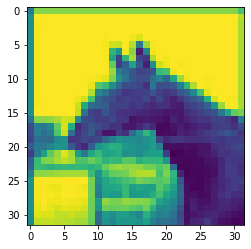

In [0]:
for idx, data in enumerate(train_dl):
  image,label=data
  plt.imshow(image[0][2].cpu().data)
  if(idx==5):
    break

**Q3.b**: Now, create your network model, testing and training loops to train your network. Plot the training curve using tensorboard, and add this plot to your writeup along with the final training and testing accuracy. Describe how you tuned your hyperparameters in your writeup along with your final hyperparameter choices. 

**Note: Do not use any convolutional layers.**

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

class MLP_Cifar(nn.Module):
  def __init__(self):
    super(MLP_Cifar, self).__init__()
    self.fc1 = nn.Linear(3072,3900)
    self.fc2 = nn.Linear(3900,1200)
    self.fc3  = nn.Linear(1200,10)


  def forward(self, x):
    x = F.leaky_relu(self.fc1(x))
    x = F.leaky_relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [0]:
netw=MLP_Cifar()
netw.cuda()
optim = optim.Adam(netw.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
netw.to(device)

MLP_Cifar(
  (fc1): Linear(in_features=3072, out_features=3900, bias=True)
  (fc2): Linear(in_features=3900, out_features=1200, bias=True)
  (fc3): Linear(in_features=1200, out_features=10, bias=True)
)

In [0]:
import os
from torch.utils.tensorboard import SummaryWriter
ACCURACY_DIR = "Cifar correct accuracy" # Sub-Directory for storing this specific experiment's logs
LOSS_DIR = "Cifar proper Loss"
cifar_acccorrect = SummaryWriter(os.path.join(ROOT_LOG_DIR, ACCURACY_DIR))
cifar_lossproper = SummaryWriter(os.path.join(ROOT_LOG_DIR, LOSS_DIR))

In [0]:
%tensorboard --logdir {ROOT_LOG_DIR.replace(" ", "\\ ")}

In [0]:
def train_model(train_dl, optim, loss_func, netw):
  #training loop
  netw.to(device)
  graph = SummaryWriter()
  overall_step = 0
  for epoch in range(10): 
      overall_loss = 0.0
      correct_values=0
      overall_loss=0
      instances=0
      for idx,data in enumerate(train_dl):
        image,label=data
        image, label = image.to(device), label.to(device)   #sending to gpu
        optim.zero_grad()
        image=image.view(image.size(0),-1)       #flattening the images
        Y_pred=netw(image)
        loss = loss_func(Y_pred,label)
        overall_loss += loss.item()
        loss.backward()
        optim.step()
        overall_step+=1
        predicted_value=torch.argmax(Y_pred,1)
        instances += image.size(0)
        correct_values+=(predicted_value == label).sum().item()
        # print(correct_values,instances)
        # if idx % 200 == 0:
        #   print((overall_loss)/(idx+1))
      # print(correct_values)
      accuracy = correct_values /len(train_dl.dataset)
      avg_loss = overall_loss /idx+1
      print(accuracy*100,avg_loss)
      # print(avg_loss)
      cifar_acccorrect.add_scalar('Cifar correct accuracy', accuracy*100, overall_step+1)
      cifar_lossproper.add_scalar('Cifar proper loss', avg_loss, overall_step+1) 

In [0]:
result=train_model(train_dl, optim, loss_func, netw)

33.29814814814815 2.842042209927521
40.885185185185186 2.645367124988814
43.8 2.5666452015407444
45.62407407407407 2.5212991949139756
47.053703703703704 2.4833008963493866
47.72777777777778 2.458592212122828
48.894444444444446 2.431386057429009
49.67962962962963 2.4092081051606398
50.43518518518518 2.3844530206791665
51.16851851851851 2.36877452288655


In [0]:
def test_model(test_dl, netw,loss_func):
  with torch.no_grad(): 
    overall_loss = 0.0
    correct_values=0
    overall_loss=0
    instances=0
    for idx,data in enumerate(test_dl):
      image,label=data
      image, label = image.to(device), label.to(device)
      optim.zero_grad()
      image=image.view(image.size(0),-1)
      Y_pred=netw(image)
      loss = loss_func(Y_pred,label)
      overall_loss += loss.item()
      predicted_value=torch.argmax(Y_pred,1)
      instances += image.size(0)
      correct_values+=(predicted_value == label).sum().item()
    accuracy = correct_values /len(test_dl.dataset)
    avg_loss = overall_loss /idx+1
    print(accuracy*100,avg_loss)

In [0]:
result_test=test_model(test_dl,netw,loss_func)

53.11296296296296 2.304047352357304


Now for submission purposes, complete the following header that returns a Numpy array with the predictions (i.e. a 0-9 label for which class each sample belongs to) for an input 3 dimensional numpy array containing CIFAR-10 data.

In [0]:
# Output: Return a numpy array with a 0-9 label for each sample in the input numpy array
# (i.e. an np array whose contents are of the form: [0, 3, 2, 4, ... , 8])

def generate_cifar_10_outputs(input):
  p=[]
  netw.to(device)
  for idx,data in enumerate(input):
    data=data.reshape(-1,3*32*32)
    actual=torch.FloatTensor(data)
    actual=actual.to(device)
    Y_pred=netw(actual)
    _,predicted_value=torch.max(Y_pred.data,1)
    p.append(predicted_value.item())
  p=np.array(p)
  return p

In [0]:
test_case_3b = generate_cifar_output(generate_cifar_10_outputs)
test_case_3b

array([6, 9, 1, ..., 1, 2, 5])

## Submission Instructions

The deadline for all parts of this assignment is **February 13, 2020 at 11:59pm**. 

There are two submissions on Gradescope:
*   HW2 - Deep Learning Diagnostics (Writeup)
*   HW2 - Deep Learning Diagnostics (Programming)

For *HW2 - Deep Learning Diagnostics (Writeup)* submit your written responses to the questions above as the file **"522_HW2_writeup.pdf"**

For *HW2 - Deep Learning Diagnostics (Programming)* submit the following files as your submission:
1.   522_HW2_submission.dill
2.   This notebook, named as 522_HW2_notebook.ipynb

**Leaderboard:** When you submit, you can choose to add yourself as part of the leaderboard! Extra credit may be awarded to those that perform particularly well on the leaderboard.

**Gradescope Score:** After you submit, you'll see that all of the classifier questions are out of zero points. To encourage as much hypertuning, we will not be releasing the accuracy cutoffs until after the late deadline has passed.

In [0]:
import dill
import os

file_to_obj_map = {
    'test_case_1e' : test_case_1e,
    'test_case_3b' : test_case_3b,
}

tests_path = "522_HW2_submission.dill"
with open(tests_path, 'wb') as pickle_file:
  dill.dump(file_to_obj_map, pickle_file)